---
layout:     post
title:      "Supreme Gridlock"
date:       2017-04-23 12:00:00
author:     Andrew
header-img: img/posts/supreme_court_seats/bench.jpg
header-credit: https://unsplash.com/@willpat
tags:       programming riddler politics puzzles
---

Last week I won the FiveThityEight [Riddler](https://fivethirtyeight.com/features/how-many-bingo-cards-are-there-in-the-world/)!  (don't get too excited, the winner is randomly selected 😉)

![winner]({{ site.baseurl }}/img/posts/supreme_court_seats/classic_winner.png)

Usually I wouldn't share every riddler I work on, but I want to post this one because it's straightforward, politically applicable, and was fun to work on.

Here is the riddle:
> Imagine that U.S. Supreme Court nominees are only confirmed if the same party holds the presidency and the Senate. What is the expected number of vacancies on the bench in the long run?    
You can assume the following:
* You start with an empty, nine-person bench.
* There are two parties, and each has a 50 percent chance of winning the presidency and a 50 percent chance of winning the Senate in each election.
* The outcomes of Senate elections and presidential elections are independent.
* The length of time for which a justice serves is uniformly distributed between zero and 40 years.

Additional clarifications I made:
* President elected every 4 years, Senate every 2 years.
* Judicial terms will be integers (whole years), and if a judge leaves on an election year, the subsequent government will nominate.

Note: I have omitted some of the plotting code in favor of just displaying the results.  Full code [here](https://github.com/andrewzwicky/puzzles/blob/master/FiveThirtyEightRiddler/2017-04-14/empty_court_seats.ipynb)

In [34]:
from enum import Enum
import itertools
import random
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from faker import Faker
from plotting import *
import matplotlib.patches as patches

fake = Faker()

%matplotlib inline

First we'll need a way to differentiate which party the Senate & President are part of.  The `Party` [enumeration](https://en.wikipedia.org/wiki/Enumerated_type) provides an easy way to assign names to the different parties.  Assigning names helps keep the code easily readable.

In [68]:
class Party(Enum):
    D = 1
    R = 2

We'll also make a class to represent each judge.  When a new `Justice` is created, they'll be assigned a party, given a fake name, and a term of somewhere between 0 and 40 years.  The names are just for fun, they don't have any impact on the solution.

In [67]:
class Justice:
    
    def __init__(self, party):
        self.name = fake.name()
        self.party = party
        self.term = random.randint(0,40)
        
        
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return "{name} [{party}] ({term} years)".format(name=self.name,
                                                        party=self.party.name,
                                                        term=self.term)

In [39]:
print(Justice(Party.D))
print(Justice(Party.R))

Robert Thomas [D] (3 years)
Mrs. Christine Smith [R] (31 years)


Our lass class is `Bench`.  This class will represent all of the `Justices` currently on the Supreme Court.  When the `Bench` is first formed, no seats will be filled.  We care about modifying the `Bench` in a few ways:

1. Filling all available seats with judges of a certain party (`fill_seats`).
2. Adding years to determine if judges have vacated their seats on any given year (`add_years`).
3. Getting the composition of the court at a particular year, used for displaying the data later (`breakdown`).

Empty seats in the court are represented by `None`, and judges are removed when they have `0` years left in their term.

In [40]:
class Bench:
    
    SIZE = 9
    
    def __init__(self):
        self.seats = [None] * self.SIZE
    
    def fill_seats(self, party):
        # loop through all seats
        for i in range(self.SIZE):
            if self.seats[i] is None:
                # if seat is empty, add new 
                # justice of the correct party
                self.seats[i] = Justice(party)
                
    def add_years(self, num_years):
        for i in range(self.SIZE):
            if self.seats[i] is not None:
                # for occupied seats, remove the given
                # number of years from their remaining
                # term.  If their term is less than 0
                # this means their seat should now
                # be empty again.
                self.seats[i].term -= num_years
                if self.seats[i].term <= 0:
                    self.seats[i] = None
    
    def breakdown(self):
        empty = 0
        dems = 0
        reps = 0
        
        for seat in self.seats:
            if seat is None:
                empty += 1
            else:
                if seat.party == Party.D:
                    dems += 1
                else:
                    reps += 1

        return (dems, empty, reps)
    
    def __repr__(self):
        return "\n".join(map(str,self.seats))

In [41]:
b = Bench()
b.fill_seats(Party.R)
b.add_years(4)
print(b)

Catherine Mendoza [R] (4 years)
Alyssa Gibson [R] (34 years)
Jamie Ross [R] (35 years)
Michael Savage [R] (12 years)
Nathaniel Baker [R] (21 years)
None
None
Melvin Medina [R] (32 years)
Henry Marshall [R] (10 years)


This is where the actual simulation begins.  This simulation will loop through years (by 2).  

At each 2 year period, Senate elections will be held.
Each 4 year period, President elections will be held.

At the end of the elections, if the government is aligned, empty seats on the bench should be filled by that party.

In [62]:
def simulate(years):
    president_party = None
    senate_party = None
    bench = Bench()
        
    for year in range(years+1):
        bench.add_years(1)
        
        if year % 2 == 0:
            senate_party = random.choice(list(Party))
        
        if year % 4 == 0:
            president_party = random.choice(list(Party))
        
        if president_party == senate_party:
            bench.fill_seats(president_party)
        
        yield year, bench.breakdown(), president_party, senate_party

In [43]:
years, benches, president_parties, senate_parties = zip(*list(simulate(200)))

bench_stacks = np.row_stack(zip(*benches))

NameError: name 'Party' is not defined

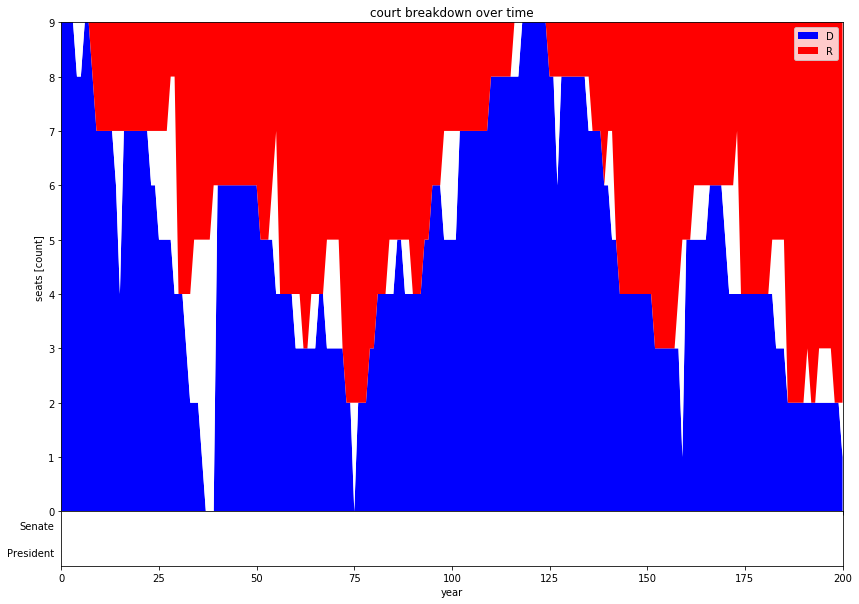

In [44]:
stacked_plot_bench_over_time_with_parties(years,
                                          bench_stacks,
                                          president_parties,
                                          senate_parties)

In [45]:
years, benches, president_parties, senate_parties = zip(*list(simulate(500)))

bench_stacks = np.row_stack(zip(*benches))

mean = np.cumsum(bench_stacks[1]) / ([1] + list(years[1:]))

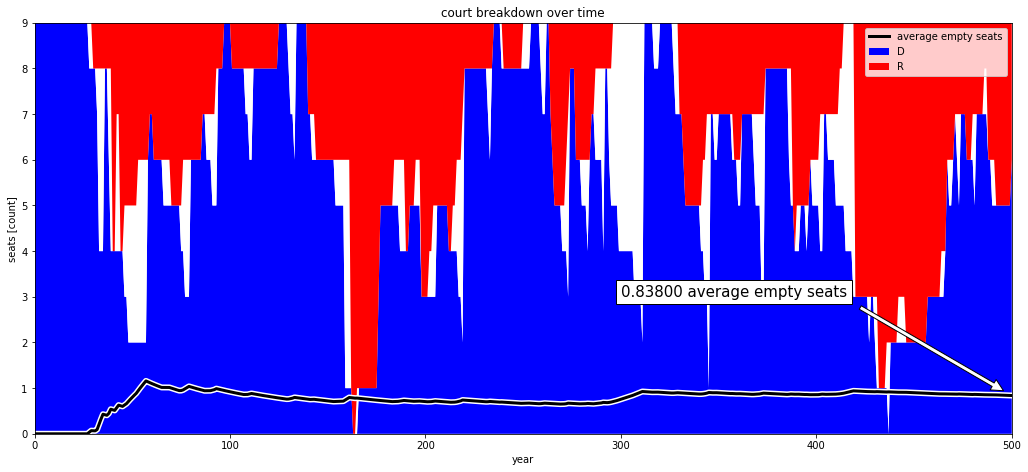

In [46]:
stacked_plot_bench_over_time(years, bench_stacks, mean)

In [73]:
simulations = []

for trial in range(20):
    years, benches, president_parties, senate_parties = zip(*list(simulate(500)))
    bench_stacks = np.row_stack(zip(*benches))
    mean = np.cumsum(bench_stacks[1]) / ([1] + list(years[1:]))
    simulations.append(mean)

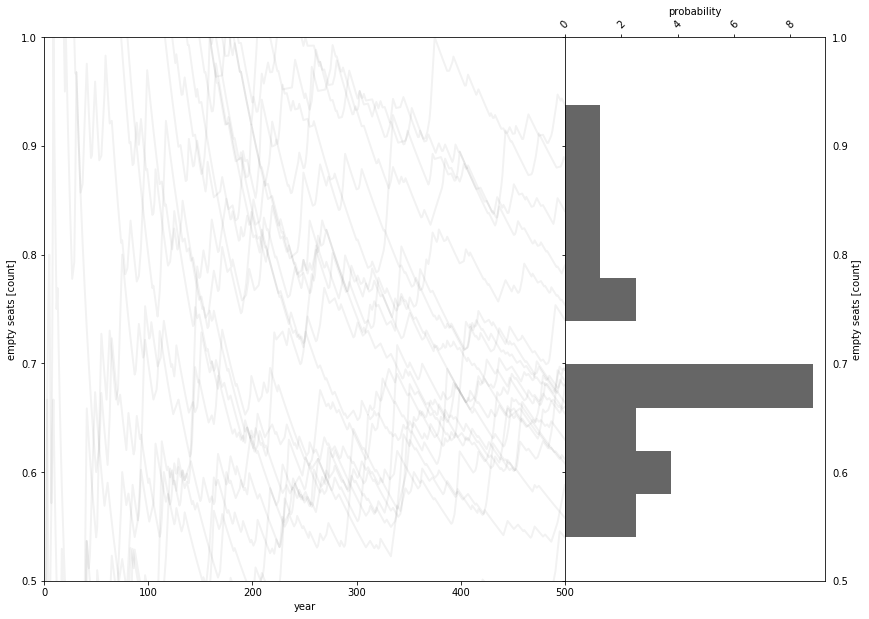

In [74]:
plot_sims(years, simulations)

## Related Reading
[https://hectorpefo.github.io/2017-04-16-supreme-vacancies/](https://hectorpefo.github.io/2017-04-16-supreme-vacancies/)    
[http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/](http://www.laurentlessard.com/bookproofs/a-supreme-court-puzzle/)